In [34]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [13]:
21 + 26 + 25

72

In [2]:
df = pd.read_csv('rhc.csv', index_col=0)
exclude_columns = ['sadmdte', 'lstctdte', 'dschdte']

# Select only the columns that are not in the exclude_columns list, keeping the original order
df_sub = df[[col for col in df.columns if col not in exclude_columns]]


In [3]:
def categorize_columns(df):
    continuous_columns = []
    binary_columns = []
    categorical_columns = []
    
    for column in df.columns:
        unique_values = df[column].nunique()
        
        if unique_values == 2:
            binary_columns.append(column)
        elif unique_values > 2 and df[column].dtype == 'object':  # Assuming categorical columns are of object type
            categorical_columns.append(column)
        else:
            continuous_columns.append(column)
    print(f"Number of continuous columns: {len(continuous_columns)}")
    print(f"Number of binary columns: {len(binary_columns)}")
    print(f"Number of categorical columns: {len(categorical_columns)}")
    return continuous_columns, binary_columns, categorical_columns
Y = df_sub['death']  
Z = df_sub['swang1']  
# Remove Y and Z from the dataframe to avoid them being categorized as confounders
df_confounders = df_sub.drop(columns=['death', 'swang1'])

# Get categorized columns
continuous_columns, binary_columns, categorical_columns = categorize_columns(df_confounders)

Number of continuous columns: 26
Number of binary columns: 25
Number of categorical columns: 6


In [4]:
### Find how many possible classes for dummy variables
k = 0
for col in categorical_columns:
    k += df_sub[col].value_counts().__len__()
k

31

In [20]:
## impute missing values
from sklearn.impute import SimpleImputer

df_continuous = df_sub[continuous_columns]

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
df_continuous_imputed = pd.DataFrame(imputer.fit_transform(df_continuous), columns=df_continuous.columns)
df_continuous_imputed.index.name = 'X'


In [23]:
df_continuous_imputed

,dthdte,age,edu,surv2md1,das2d3pc,t3d30,aps1,scoma1,meanbp1,wblc1,...,bili1,crea1,sod1,pot1,paco21,ph1,wtkilo1,adld3p,urin1,ptid
X,,,,,,,,,,,,,,,,,,,,,
0,11753.869156,70.25098,12.000000,0.640991,23.50000,30.0,46.0,0.0,41.0,22.097656,...,1.009766,1.199951,145.0,4.000000,40.0,7.359375,64.69995,0.000000,2192.453665,5.0
1,11844.000000,78.17896,12.000000,0.755000,14.75195,30.0,50.0,0.0,63.0,28.898438,...,0.699951,0.599976,137.0,3.299805,34.0,7.329102,45.69998,1.182071,1437.000000,7.0
2,11753.869156,46.09198,14.069916,0.317000,18.13672,30.0,82.0,0.0,57.0,0.049995,...,1.009766,2.599609,146.0,2.899902,16.0,7.359375,0.00000,1.182071,599.000000,9.0
3,11183.000000,75.33197,9.000000,0.440979,22.92969,30.0,48.0,0.0,55.0,23.296875,...,0.399963,1.699951,117.0,5.799805,30.0,7.459961,54.59998,1.182071,2192.453665,10.0
4,12037.000000,67.90997,9.945259,0.437000,21.05078,2.0,72.0,41.0,65.0,29.699219,...,1.009766,3.599609,126.0,5.799805,17.0,7.229492,78.39996,1.182071,64.000000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,11753.869156,75.56195,6.000000,0.544000,14.75195,30.0,45.0,9.0,60.0,22.796875,...,0.799927,1.599854,124.0,3.799805,30.0,7.539062,78.19995,1.182071,1285.000000,10270.0
5731,12629.000000,44.65698,12.000000,0.637000,23.00000,30.0,62.0,0.0,62.0,5.199219,...,1.009766,2.799805,141.0,3.799805,30.0,7.509766,50.50000,0.000000,1010.000000,10272.0
5732,12396.000000,80.48499,17.000000,0.740000,17.50000,30.0,43.0,0.0,168.0,27.898438,...,1.000000,1.099854,143.0,5.099609,58.0,7.219727,86.00000,1.000000,4638.000000,10273.0


In [38]:
df_binary = df_sub[binary_columns]
def binary_encode(df, column):
    unique_values = df[column].dropna().unique()
    if len(unique_values) == 2:
        df[column] = df[column].map({unique_values[0]: 0, unique_values[1]: 1})
    return df

# Applying the binary_encode function to each binary column
df_binary_encoded = df_binary.copy()
for col in df_binary.columns:
    df_binary_encoded = binary_encode(df_binary_encoded, col)

In [7]:
df_categorical = df_sub[categorical_columns]

# Convert categorical columns to dummy variables, creating an additional dummy column for NaN values
df_categorical_dummies = pd.get_dummies(df_categorical, dummy_na=True, drop_first=True)

In [9]:
## Modify the column names to suuit the statsmodels syntax
def clean_column_names(columns):
    cleaned_columns = [col.replace(" ", "_").replace("/", "_").replace("-", "_").replace("&", "and").replace("$", "").replace(">", "gt") for col in columns]
    return cleaned_columns

# Clean column names in each dataframe
df_continuous_imputed.columns = clean_column_names(df_continuous_imputed.columns)
df_binary.columns = clean_column_names(df_binary.columns)
df_categorical_dummies.columns = clean_column_names(df_categorical_dummies.columns)

continuous_vars = " + ".join(df_continuous_imputed.columns)
binary_vars = " + ".join([f"C({col})" for col in df_binary.columns])
categorical_dummies_vars = " + ".join(df_categorical_dummies.columns)



In [37]:
df_binary.sex

0         Male
1       Female
2       Female
3       Female
4         Male
         ...  
5730      Male
5731    Female
5732      Male
5733      Male
5734    Female
Name: sex, Length: 5735, dtype: object

In [45]:
df_continuous_imputed.reset_index(drop=True, inplace=True)
df_binary.reset_index(drop=True, inplace=True)
df_categorical_dummies.reset_index(drop=True, inplace=True)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Applying PolynomialFeatures to the binary-encoded DataFrame and updating column names
df_binary_poly = pd.DataFrame(poly.fit_transform(df_binary_encoded))
binary_feature_names = poly.get_feature_names_out(input_features=df_binary_encoded.columns)
df_binary_poly.columns = binary_feature_names

# Applying PolynomialFeatures to the categorical dummies DataFrame and updating column names
df_categorical_dummies_poly = pd.DataFrame(poly.fit_transform(df_categorical_dummies))
categorical_feature_names = poly.get_feature_names_out(input_features=df_categorical_dummies.columns)
df_categorical_dummies_poly.columns = categorical_feature_names
# 3. Standardization/Scaling
scaler = StandardScaler()
df_binary_poly_scaled = pd.DataFrame(scaler.fit_transform(df_binary_poly), columns=df_binary_poly.columns)
df_categorical_dummies_poly_scaled = pd.DataFrame(scaler.fit_transform(df_categorical_dummies_poly), columns=df_categorical_dummies_poly.columns)
df_continuous_imputed_scaled = pd.DataFrame(scaler.fit_transform(df_continuous_imputed), columns=df_continuous_imputed.columns)

# Concatenating the dataframes
df_confounders_all = pd.concat([df_continuous_imputed_scaled, df_binary_poly_scaled, df_categorical_dummies_poly_scaled], axis=1)

# # Concatenating the dataframes
# df_confounders_all = pd.concat([df_continuous_imputed, df_binary, df_categorical_dummies], axis=1)

# Define the treatment variable Z

Z = df_sub['swang1']  # Assuming 'swang1' indicates whether RHC was received within 24 hours of admission
Z_bin = Z.replace({'RHC': 1, 'No RHC': 0})
X = df_confounders_all
y = Z_bin

# Create a logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X, y)

# Get the propensity scores, which are the probabilities of receiving the treatment
propensity_scores = log_reg.predict_proba(X)[:, 1]

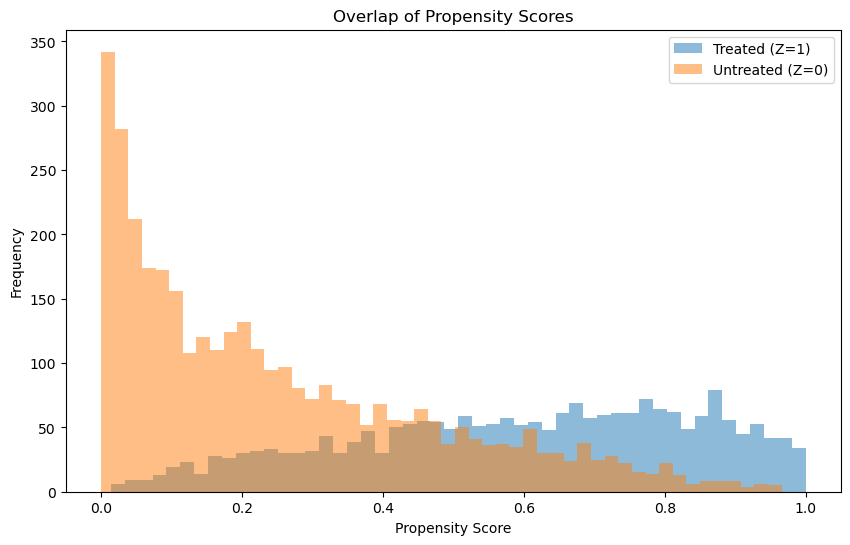

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `propensity_scores` and `Z_bin` are your propensity scores and treatment assignment
treated_scores = propensity_scores[Z_bin == 1]
untreated_scores = propensity_scores[Z_bin == 0]

plt.figure(figsize=(10, 6))
plt.hist(treated_scores, bins=50, alpha=0.5, label='Treated (Z=1)')
plt.hist(untreated_scores, bins=50, alpha=0.5, label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Overlap of Propensity Scores')
plt.legend()
plt.show()


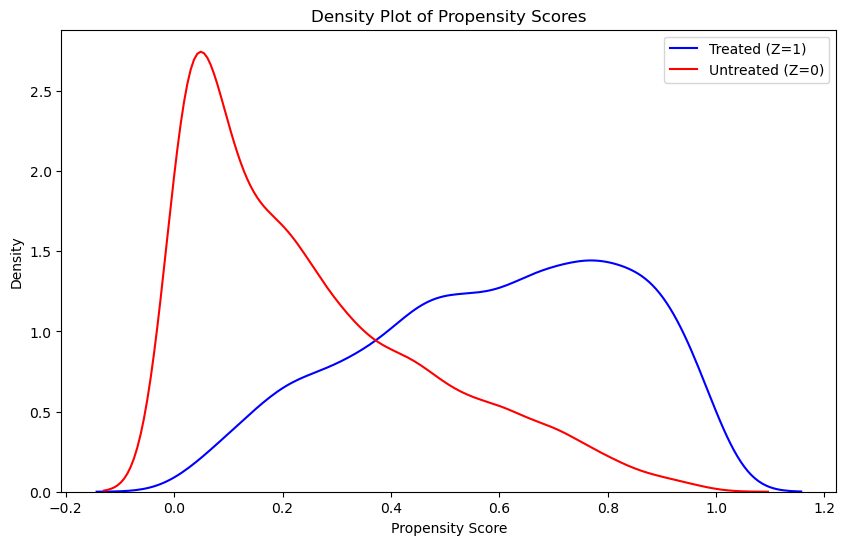

In [48]:
plt.figure(figsize=(10, 6))
sns.kdeplot(treated_scores, color='blue', label='Treated (Z=1)')
sns.kdeplot(untreated_scores, color='red', label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Density Plot of Propensity Scores')
plt.legend()
plt.show()
